<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Data Preparation**

**Methodology:**
We begin by working with a MovieLens-style dataset that includes user ratings, movie metadata (titles and genres), and user demographics. The goal is to prepare the data for both **collaborative filtering** and **content-based filtering**.

* For collaborative filtering, we construct a **User-Item Matrix**, where each cell represents a known rating by a user for a movie.
* For content-based filtering, we extract movie **genre labels**, perform **one-hot encoding**, and create **genre vectors**.
* For enhanced UBCF, we also prepare user demographic features (e.g., gender, age, occupation) to compute **demographic similarity**.

**Pseudo-Formulae:**

* **User-Item Matrix**

  $$
  \text{UserItem}[u, m] = \text{Rating of user } u \text{ for movie } m
  $$

* **Genre Vectors (One-Hot Encoded)**

  $$
  \text{GenreVector}[m] = [\text{Action}=1, \text{Drama}=0, \ldots]
  $$

* **User Demographic Vectors (One-Hot + Scaled)**

  $$
  \text{UserFeatures}[u] = \text{OneHot}(Gender, Occupation) + \text{Scaled}(Age)
  $$


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load Data ---
ratings = pd.read_csv("ratings.dat", sep="::", engine="python", names=["userId", "movieId", "rating", "timestamp"])
movies = pd.read_csv("movies.dat", sep="::", engine="python", encoding="ISO-8859-1",
                     names=["movieId", "title", "genres"])
users = pd.read_csv("users.dat", sep="::", engine="python", names=["userId", "gender", "age", "occupation", "zip"])

print("Ratings \n")
print(ratings.head())
print("Movies \n")
print(movies.head())
print("Users \n")
print(users.head())

# --- Merge Ratings with Users and Movies (Optional for analysis or hybrid features) ---
ratings_full = ratings.merge(users, on="userId").merge(movies, on="movieId")

# --- One-hot Encode Genres ---
movies["genres"] = movies["genres"].str.split("|")
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies["genres"]),
    columns=mlb.classes_,
    index=movies["movieId"]
)

# --- Train-Test Split for Ratings ---
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Create User-Item Matrix ---
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)



Ratings 

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Movies 

   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
Users 

   userId gender  age  occupation    zip
0       1      F    1          10  48067
1       2      M   56          16  70072
2       3      M   25          15  55117
3       4      M   45           7  02460
4       5      M   25          20  55455


### **2. User-Based Collaborative Filtering (UBCF)**

**Methodology:**
UBCF recommends items by finding users with similar rating behavior. To improve recommendation quality, we enhance the similarity calculation by blending in **demographic similarity**.

**Pseudocode:**

1. Compute Rating-Based User Similarity
   - Input: User-Item Rating Matrix
   - Method: Cosine Similarity between users based on their rating vectors

2. Compute Demographic-Based User Similarity
   - Extract demographic features: gender, occupation, age
   - One-hot encode gender and occupation
   - Standardize age
   - Concatenate features to form demographic vectors
   - Compute Cosine Similarity between users based on demographic vectors

3. Combine Both Similarities
    - Define weight α (α = 0.9 for 90% emphasis on ratings)
    - Compute: CombinedSimilarity = α * RatingSimilarity + (1 - α) * DemographicSimilarity

4. Predict a User’s Rating for a Movie
   - If movie not rated by any similar users → return NaN
   - For each other user:
       If user rated the movie:

```
PredictedRating = Σ[sim(u,v) × r(v,m)] / Σ[sim(u,v)]
```

Where:

* `u` = target user
* `v` = other users who rated movie `m`
* `sim(u,v)` = similarity between user `u` and user `v`
* `r(v,m)` = rating given by user `v` to movie `m`


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# --- Step 1: Compute Rating-Based Similarity ---
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 2: Compute Demographic-Based Similarity ---
# Ensure userId is index-matched with user_item_matrix
users_filtered = users.set_index("userId").loc[user_item_matrix.index]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
gender_occ_encoded = encoder.fit_transform(users_filtered[['gender', 'occupation']])

# Normalize numerical features
scaler = StandardScaler()
age_scaled = scaler.fit_transform(users_filtered[['age']])

# Combine features
user_features = np.hstack([gender_occ_encoded, age_scaled])

# Compute demographic similarity
demo_similarity = cosine_similarity(user_features)
demo_similarity_df = pd.DataFrame(demo_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 3: Blend Similarities ---
alpha = 0.9  # weight for rating-based similarity
combined_similarity = alpha * user_similarity_df + (1 - alpha) * demo_similarity_df
combined_similarity_df = pd.DataFrame(combined_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 4: Define Prediction Function Using Combined Similarity ---
def predict_ubcf(user_id, movie_id):
    if movie_id not in user_item_matrix.columns or user_id not in combined_similarity_df.index:
        return np.nan
    sims = combined_similarity_df.loc[user_id]
    ratings = user_item_matrix[movie_id]
    mask = ratings > 0
    return np.dot(sims[mask], ratings[mask]) / sims[mask].sum() if sims[mask].sum() > 0 else np.nan

# To print 5 rows and 7 columns of the combined_similarity_df
print(combined_similarity_df.iloc[:5, :7])


userId         1         2         3         4         5         6         7
userId                                                                      
1       1.000000 -0.022655  0.145491  0.019786  0.058190  0.123132  0.045572
2      -0.022655  1.000000  0.123580  0.192415  0.097653  0.156793  0.315099
3       0.145491  0.123580  1.000000  0.095511  0.083033  0.029408  0.138952
4       0.019786  0.192415  0.095511  1.000000  0.054477  0.045036  0.182761
5       0.058190  0.097653  0.083033  0.054477  1.000000  0.013558  0.132232


### **3. Content-Based Filtering (CBF)**

**Methodology:**
CBF recommends items by comparing their **content features**, rather than relying on user-to-user similarity. In this case, we represent each movie by its **genre vector**, computed via one-hot encoding. We then use **cosine similarity** to identify movies similar in genre to those a user has already rated highly.

For any user and unseen movie, the system predicts how much the user will like it by looking at:

* How similar the movie is to those the user liked
* How highly the user rated those similar movies

**Pseudocode:**

i. Represent Movies by Genre Vectors

   * Input: Genre labels for each movie
   * Split genre strings into lists
   * One-hot encode genres
   * Output: Genre matrix (Movie × Genre)

ii. Compute Movie-to-Movie Similarity

   * Method: Cosine similarity between genre vectors
   * Output: Movie similarity matrix (Movie × Movie)

iii. Predict a User’s Rating for a Movie

   * For target user $u$ and movie $i$:

     * Get movies $j$ rated by $u$
     * Retrieve similarities $\text{sim}(i, j)$
     * Retrieve ratings $r(u, j)$
     * Compute:


```
PredictedRating = Σ[sim(i,j) × r(u,j)] / Σ[sim(i,j)]
```

Where:

* `i` = target movie
* `j` = movies the user `u` has already rated
* `sim(i,j)` = similarity between target movie `i` and movie `j`
* `r(u,j)` = rating user `u` gave to movie `j`


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np

# --- Step 1: One-hot Encode Movie Genres ---
# Ensure all genres are lists and not NaNs
movies["genres"] = movies["genres"].apply(lambda x: x if isinstance(x, list) else [])

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies["genres"]),
    columns=mlb.classes_,
    index=movies["movieId"]
)


# --- Step 2: Compute Movie-to-Movie Similarity ---
movie_similarity = cosine_similarity(genre_matrix)
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=genre_matrix.index,
    columns=genre_matrix.index
)

# --- Step 3: Define Content-Based Prediction Function ---
def predict_cbf(user_id, target_movie_id):
    if user_id not in user_item_matrix.index or target_movie_id not in movie_similarity_df.index:
        return np.nan

    # Get movies rated by the user
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index

    if rated_movies.empty:
        return np.nan

    # Compute weighted average of ratings using genre similarity
    sims = movie_similarity_df.loc[target_movie_id, rated_movies]
    ratings = user_ratings[rated_movies]

    sim_sum = sims.sum()
    return np.dot(sims, ratings) / sim_sum if sim_sum > 0 else np.nan

# --- Step 4: Preview Similarity Matrix (5 rows × 7 columns) ---
print(movie_similarity_df.iloc[:5, :7])


movieId         1         2         3         4         5    6         7
movieId                                                                 
1        1.000000  0.333333  0.408248  0.408248  0.577350  0.0  0.408248
2        0.333333  1.000000  0.000000  0.000000  0.000000  0.0  0.000000
3        0.408248  0.000000  1.000000  0.500000  0.707107  0.0  1.000000
4        0.408248  0.000000  0.500000  1.000000  0.707107  0.0  0.500000
5        0.577350  0.000000  0.707107  0.707107  1.000000  0.0  0.707107


### 4. Personalized Top-N Recommendation Generation: Purpose and Methodology

We will generate a tailored list of top-N movie recommendations for user_id=6040 by UBCF and CBF to estimates how much the user would like each unseen movie.

**Step-by-Step Methodology**

i. **Separate Seen from Unseen Movies**
   The system examines the user's rating history to identify which movies have already been rated. All remaining movies are considered unseen and thus eligible for recommendation.

ii. **Score Unseen Movies Using a Prediction Function**
   The prediction functions for content-based filtering (CBF) and user-based collaborative filtering (UBCF) — are applied to each unseen movie to estimate the user's likely rating.

iii. **Filter and Rank Predictions**
   The predicted scores are filtered to exclude missing values (NaN). The remaining scores are sorted in descending order to prioritize the highest recommendations.

iv. **Return Top-N Results**
   The top-N movie IDs with the highest predicted scores are selected as the final personalized recommendations.

**Prediction Logic (Pseudocode)**

```
For each movie m that user u has not rated:
    predicted_score = predict_fn(user u, movie m)

Keep predictions where predicted_score is valid
Sort all predicted movies by predicted_score in descending order
Return the top N results
```

This method provides a scalable way to evaluate any recommendation strategy, ensuring consistent performance evaluation across different models.


In [5]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_user_predictions(user_id, predict_fn, top_n=50):
    seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    unseen = user_item_matrix.columns.difference(seen)

    recs = []
    for mid in unseen:
        score = predict_fn(user_id, mid)
        if not np.isnan(score):
            recs.append((mid, score))

    return sorted(recs, key=lambda x: x[1], reverse=True)[:top_n]


# Generate and display top-50 movie recommendations for user 6040 using both UBCF and CBF

# --- UBCF Recommendations ---
top_recommendations_ubcf = get_user_predictions(user_id=6040, predict_fn=predict_ubcf, top_n=50)
top_ubcf_df = pd.DataFrame(top_recommendations_ubcf, columns=['movieId', 'PredictedScore'])
print("Print the Top 10 UBCF Recommendations:")
print(top_ubcf_df.head(10))

# --- CBF Recommendations ---
top_recommendations_cbf = get_user_predictions(user_id=6040, predict_fn=predict_cbf, top_n=50)
top_cbf_df = pd.DataFrame(top_recommendations_cbf, columns=['movieId', 'PredictedScore'])
print("\nPrint the Top 10 CBF Recommendations:")
print(top_cbf_df.head(10))



Print the Top 10 UBCF Recommendations:
   movieId  PredictedScore
0     3233             5.0
1      729             5.0
2      787             5.0
3      989             5.0
4     1830             5.0
5     3172             5.0
6     3245             5.0
7     3280             5.0
8     3517             5.0
9     3607             5.0

Print the Top 10 CBF Recommendations:
   movieId  PredictedScore
0       37        4.571429
1       77        4.571429
2       99        4.571429
3      108        4.571429
4      116        4.571429
5      128        4.571429
6      134        4.571429
7      136        4.571429
8      137        4.571429
9      162        4.571429


### 5. Model Evaluation

**Methodology:**

Next we evaluate `UBCF` and `CBF` using RMSE and MAE on the test set as required by Project 4. These measure how close predicted ratings are to actual ratings.

Pseudo-Formulas:

```
RMSE = sqrt(mean((actual - predicted)^2))
MAE = mean(|actual - predicted|)
```

Evaluating CBF: 100%|██████████| 200042/200042 [04:44<00:00, 702.22it/s]


  Model      RMSE       MAE
0  UBCF  0.975643  0.779365
1   CBF  1.015956  0.811682


<Axes: title={'center': 'Model Evaluation'}, xlabel='Model'>

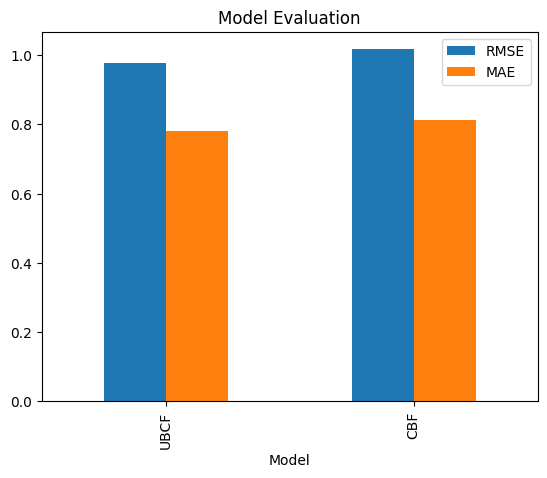

In [6]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_model_parallel(predict_fn, test_df, label, n_jobs=-1):
    def safe_predict(row):
        pred = predict_fn(row['userId'], row['movieId'])
        return (row['rating'], pred) if not np.isnan(pred) else None

    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(safe_predict)(row) for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Evaluating {label}")
    )

    # Filter out failed predictions
    results = [r for r in results if r is not None]
    actuals, predictions = zip(*results) if results else ([], [])

    if not predictions:
        return {'Model': label, 'RMSE': np.nan, 'MAE': np.nan}

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return {'Model': label, 'RMSE': rmse, 'MAE': mae}

ubcf_eval = evaluate_model_parallel(predict_ubcf, test_df, "UBCF")
cbf_eval = evaluate_model_parallel(predict_cbf, test_df, "CBF")
metrics_df = pd.DataFrame([ubcf_eval, cbf_eval])

print(metrics_df)

metrics_df.plot(kind="bar", x="Model", y=["RMSE", "MAE"], title="Model Evaluation")


### 6. Reranking for Diversity

### Purpose and Methodology: Diversity-Enhanced Re-Ranking for CBF and UBCF

**Purpose:**
This approach re-ranks the top recommendations from *Content-Based Filtering (CBF)* and *User-Based Collaborative Filtering (UBCF)* to improve **diversity**. It discourages selecting similar items by penalizing recommendations that are too close to already selected ones. The goal is to expose users to a more varied set of items, enhancing user satisfaction and coverage.

**Methodology:**

i. **Input:**

   * `recs`: Ranked list of top-N recommended movies based on predicted scores.
   * `sim_matrix`: Precomputed cosine similarity matrix between all movies.
   * `alpha`: Penalty factor controlling the tradeoff between accuracy and diversity.

ii. **Re-Ranking Logic:**

   * Start with an empty selection.
   * For each movie in the input list:

     * Compute its average similarity to already selected items.
     * Apply a diversity penalty to its score:
       `adjusted_score = original_score - alpha × average_similarity`
     * Add the movie to the selection list.
   * Sort the re-ranked list by adjusted score.

iii. **Application:**

   * Run this process separately on the CBF and UBCF recommendation outputs.
   * Merge results with movie titles for display.

**Pseudocode for Key Step:**

`diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)`

```text
For each movie in top_recommendations_cbf:
    If no movies selected yet:
        penalty = 0
    Else:
        penalty = sum of similarities to all selected movies

    adjusted_score = predicted_score - alpha × penalty
    Append (movieId, adjusted_score) to reranked list
    Add movieId to selected list

Return reranked list sorted by adjusted_score (descending)
```

This re-ranking process ensures the final top-N list favors **diverse but relevant** items, helping both CBF and UBCF models produce richer and less redundant recommendations.


/tmp/ipython-input-7-2192252441.py:93: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


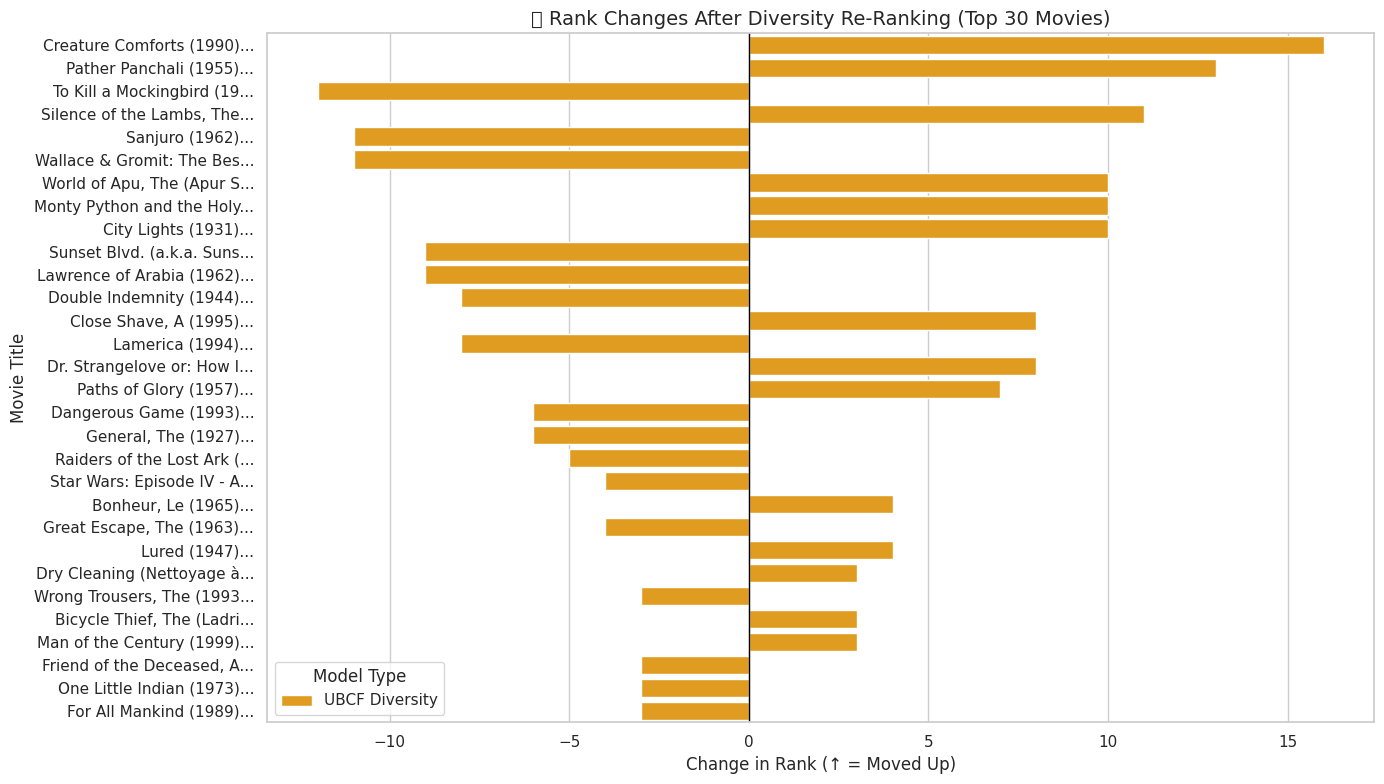

In [7]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Diversity Reranker Function ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    """
    Re-rank a list of recommendations to promote diversity using a greedy penalty approach.

    Parameters:
    - recs: List of tuples [(movieId, predicted_score), ...]
    - sim_matrix: Pandas DataFrame of movie-to-movie similarities
    - alpha: Diversity penalty weight (higher = more diversity)

    Returns:
    - List of re-ranked tuples [(movieId, adjusted_score), ...]
    """
    reranked = []
    selected = []

    for movie_id, score in recs:
        # Compute similarity penalty with already selected items
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))  # <-- Append result here
        selected.append(movie_id)

    # Sort by adjusted score (higher is better)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)
diverse_df_cbf = pd.DataFrame(diverse_cbf, columns=["movieId", "adjusted_score"])
diverse_df_cbf = diverse_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_cbf["RankType"] = "Diversity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
diverse_ubcf = rerank_diverse(top_recommendations_ubcf, combined_similarity_df, alpha=0.7)
diverse_df_ubcf = pd.DataFrame(diverse_ubcf, columns=["movieId", "adjusted_score"])
diverse_df_ubcf = diverse_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_ubcf["RankType"] = "Diversity Boosted (UBCF)"

# --- Function to Calculate Rank Changes ---
def rank_change_df(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    rerank_df = pd.DataFrame(reranked[:50], columns=["movieId", "adjusted_score"])
    rerank_df["NewRank"] = range(1, len(rerank_df) + 1)

    merged = original_df.merge(rerank_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Create Rank Change DataFrames for Each Model ---
rank_shift_cbf = rank_change_df(top_recommendations_cbf, diverse_cbf, "CBF Diversity")
rank_shift_ubcf = rank_change_df(top_recommendations_ubcf, diverse_ubcf, "UBCF Diversity")

# --- Combine Them ---
rank_shift_combined = pd.concat([rank_shift_cbf, rank_shift_ubcf], ignore_index=True)

# --- Select Top 30 Shifts for Clarity ---
rank_shift_vis = rank_shift_combined.copy()
rank_shift_vis["title_short"] = rank_shift_vis["title"].str.slice(0, 25) + "..."

# Only include top 30 by absolute change, or just slice top 30 if you prefer
top_shift = rank_shift_vis.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

# Set up plot aesthetics
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# --- Plot ---
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Diversity": "steelblue", "UBCF Diversity": "orange"}
)

# --- Labels and Layout ---
ax.axvline(0, color='black', linewidth=1)
plt.title("🎬 Rank Changes After Diversity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


* This chart shows how movie ranks changed after applying diversity re-ranking to UBCF recommendations.

* **Bars to the right** (positive values):

  * Indicate movies that **moved up in rank**.
  * These were favored for being **more unique** compared to earlier selections.
  * Examples: *Creature Comforts (1990)* and *Pather Panchali (1955)* saw large positive shifts.

* **Bars to the left** (negative values):

  * Indicate movies that **dropped in rank**.
  * These were likely **too similar** to already selected movies and were penalized.
  * Examples: *Double Indemnity (1944)* and *Lamerica (1994)*.

* The re-ranking process promotes **variety** by penalizing redundancy and favoring less similar movies, resulting in a **more diverse recommendation set**.



### 7. Reranking for Serendipity

**Purpose and Methodology: Serendipity-Based Re-Ranking for CBF and UBCF**

**Purpose:**
This method aims to increase *serendipity* in recommendations by penalizing overly similar items to what the user has already seen. The goal is to surface **unexpected yet relevant** items, providing a sense of novelty without sacrificing usefulness.

**Methodology:**

i. **Inputs:**

   * `user_id`: The target user.
   * `recs`: List of top-N movie recommendations based on base predictions.
   * `sim_matrix`: Movie-to-movie similarity matrix (e.g., cosine).
   * `uim`: Full user-item rating matrix (used to retrieve seen movies).
   * `beta`: Penalty weight for similarity to previously seen items.

ii. **Serendipity Re-Ranking Logic:**

   * Identify all movies the user has already rated.
   * For each candidate recommendation:

     * Compute its average similarity to the seen movies.
     * Adjust the recommendation score as:
       `adjusted_score = predicted_score - beta × similarity_to_seen`
   * Sort by the adjusted score in descending order.

iii. **Execution for Both Models:**

   * Use this re-ranking method separately on:

     * `top_recommendations_cbf` from the CBF model.
     * `top_recommendations_ubcf` from the UBCF model.
   * Merge results with movie titles for output and comparison.

**Pseudocode:**

```text
For each movie in recommended list:
    If user has seen movies:
        Compute average similarity to all seen movies
    Else:
        Similarity = 0
    Adjust score: predicted_score - beta × similarity
    Store adjusted score and movie
Sort all movies by adjusted score
```

This re-ranking method for **CBF and UBCF** enhances user experience by recommending items that are **useful yet pleasantly surprising**, boosting perceived personalization and engagement.


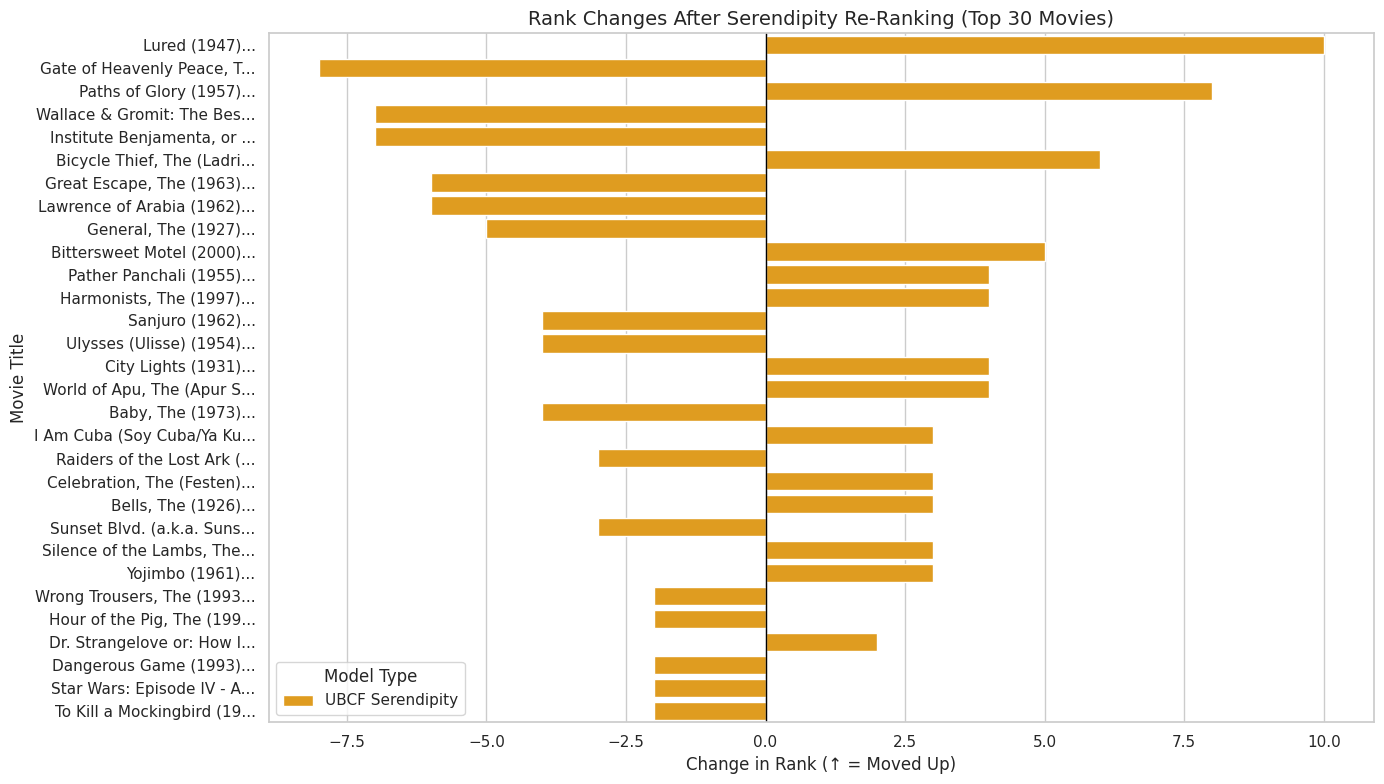

In [8]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Serendipity Reranker Function ---
def rerank_serendipity(user_id, recs, sim_matrix, uim, beta=0.5):
    seen = uim.loc[user_id]
    seen_items = seen[seen > 0].index.tolist()
    reranked = []
    for movie_id, score in recs:
        sim = sim_matrix.loc[movie_id, seen_items].mean() if seen_items else 0
        reranked.append((movie_id, score - beta * sim))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
serendipity_cbf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_cbf,
    sim_matrix=movie_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_cbf = pd.DataFrame(serendipity_cbf, columns=["movieId", "SerendipityScore"])
serendipity_df_cbf = serendipity_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_cbf["RankType"] = "Serendipity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
serendipity_ubcf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_ubcf,
    sim_matrix=combined_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_ubcf = pd.DataFrame(serendipity_ubcf, columns=["movieId", "SerendipityScore"])
serendipity_df_ubcf = serendipity_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_ubcf["RankType"] = "Serendipity Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_serendipity(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "SerendipityScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
ser_rank_cbf = rank_change_serendipity(top_recommendations_cbf, serendipity_cbf, "CBF Serendipity")
ser_rank_ubcf = rank_change_serendipity(top_recommendations_ubcf, serendipity_ubcf, "UBCF Serendipity")
ser_rank_combined = pd.concat([ser_rank_cbf, ser_rank_ubcf], ignore_index=True)

# --- Step 3: Plot Rank Changes ---
plot_data = ser_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Serendipity": "steelblue", "UBCF Serendipity": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Serendipity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


### 7. Reranking for Novelty

**Methodology for Novelty-Aware Re-Ranking (for CBF and UBCF)**

**Purpose**:
This method adjusts the recommendation scores to favor *less popular* (i.e., more novel) items. By penalizing popular movies, the system aims to introduce users to new or less commonly seen content, increasing novelty and exploration.

**Approach**:

i. **Compute Item Popularity**

   * Count the number of ratings per item from the training data.
   * Normalize each item's popularity by dividing by the maximum observed popularity.

ii. **Define Novelty Score Adjustment**

   * For each recommended movie, compute:

     ```
     penalty = gamma × (popularity / max_popularity)
     adjusted_score = predicted_score - penalty
     ```
   * Here, `gamma` controls the strength of the novelty penalty. A higher gamma favors less popular items more aggressively.

iii. **Apply to Both Models**:

   * For **CBF (Content-Based Filtering)**: Apply novelty re-ranking to the predicted list from the content-based model.
   * For **UBCF (User-Based Collaborative Filtering)**: Apply the same penalty-based re-ranking to its predicted list.

iv. **Outcome**:

   * The adjusted scores promote movies that are both relevant and less popular.
   * The top-N recommendations are re-sorted by the new scores to boost novelty without completely discarding relevance.


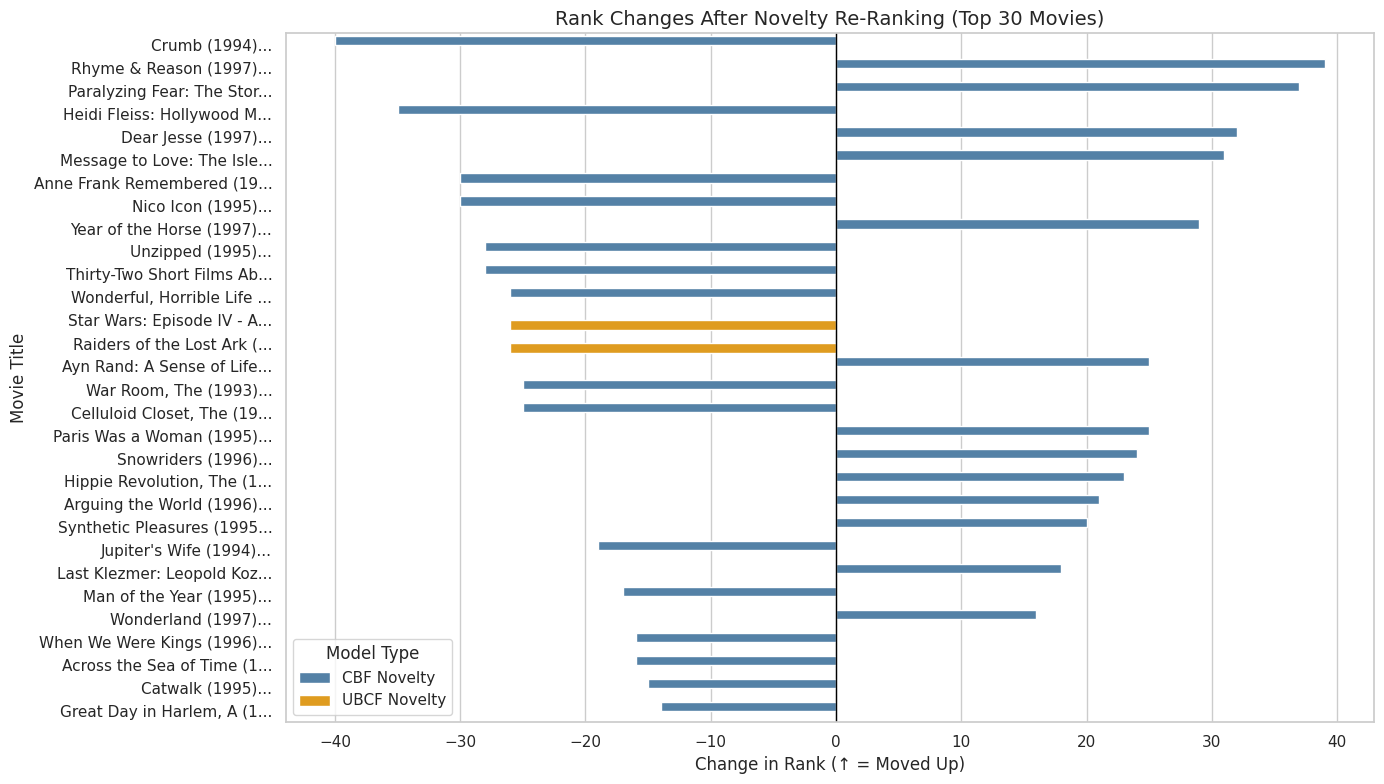

In [9]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Compute item popularity from training data ---
item_popularity = train_df.groupby("movieId").size()
max_popularity = item_popularity.max()

# --- Step 2: Define the novelty reranking function ---
def rerank_novelty(recs, gamma=0.3):
    reranked = []
    for movie_id, score in recs:
        pop = item_popularity.get(movie_id, 0) / max_popularity
        adjusted_score = score - gamma * pop
        reranked.append((movie_id, adjusted_score))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
novelty_cbf = rerank_novelty(top_recommendations_cbf, gamma=0.3)
novelty_df_cbf = pd.DataFrame(novelty_cbf, columns=["movieId", "NoveltyScore"])
novelty_df_cbf = novelty_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_cbf["RankType"] = "Novelty Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
novelty_ubcf = rerank_novelty(top_recommendations_ubcf, gamma=0.3)
novelty_df_ubcf = pd.DataFrame(novelty_ubcf, columns=["movieId", "NoveltyScore"])
novelty_df_ubcf = novelty_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_ubcf["RankType"] = "Novelty Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_novelty(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "NoveltyScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
novelty_rank_cbf = rank_change_novelty(top_recommendations_cbf, novelty_cbf, "CBF Novelty")
novelty_rank_ubcf = rank_change_novelty(top_recommendations_ubcf, novelty_ubcf, "UBCF Novelty")
novelty_rank_combined = pd.concat([novelty_rank_cbf, novelty_rank_ubcf], ignore_index=True)

plot_data = novelty_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Novelty": "steelblue", "UBCF Novelty": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Novelty Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


**Comparison of the three re-ranking strategies** based on the visualized rank changes**

***1. Diversity Re-Ranking (UBCF)***

* Promotes **distinct movies** by penalizing those too similar to already selected ones.
* Most changes are **positive**, with many movies moving up by 5–15 ranks.
* Example winners: *Creature Comforts (1990)*, *Pather Panchali (1955)*.
* Result: A balanced recommendation list with more varied content.

***2. Serendipity Re-Ranking (UBCF)***

* Rewards **unusual but relevant** items based on novelty relative to the user's history.
* Changes are more moderate than diversity, with movements between -5 to +10 ranks.
* Fewer large shifts, suggesting serendipity adds surprise without disrupting high-scoring items as much.
* Example climber: *Lured (1947)*.

***3. Novelty Re-Ranking (CBF & UBCF)***

* Strongly penalizes **popular movies** to surface lesser-known titles.
* **Largest magnitude of rank changes**, especially for CBF (drops >30 ranks).
* Many obscure documentaries and indie titles surged forward.
* Most aggressive in reshaping the list; risk of over-prioritizing unfamiliar content.

***Conclusion***

* **Diversity** creates a well-rounded list by avoiding redundancy.
* **Serendipity** subtly introduces surprises without major disruption.
* **Novelty** heavily favors unpopular content, drastically reshaping recommendations—ideal for users seeking discovery over familiarity.

Each method serves a different goal and can be selected based on whether the priority is *variety*, *surprise*, or *discovery*.


### 8. Top-N Recommendations & Visualization

**Methodology:**

We generate a top-N list using base model predictions, then rerank them using diversity, serendipity, and novelty adjustments. We compare the final movie titles.

In [10]:
from IPython.display import display, HTML
import pandas as pd

# --- Shared Helper Function ---
def get_top_n(user_id, model_fn, N=50):
    seen = user_item_matrix.loc[user_id]
    unseen = user_item_matrix.columns.difference(seen[seen > 0].index)
    preds = [(mid, model_fn(user_id, mid)) for mid in unseen]
    return sorted([r for r in preds if not np.isnan(r[1])], key=lambda x: x[1], reverse=True)[:N]

def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# --- User ID to Evaluate ---
user_id = 6040

# ======== CONTENT-BASED FILTERING (CBF) ========
top50_cbf = get_top_n(user_id, predict_cbf, N=50)

top10_cbf = top50_cbf[:30]
top10_diverse_cbf = rerank_diverse(top50_cbf, movie_similarity_df)[:30]
top10_serendipity_cbf = rerank_serendipity(user_id, top50_cbf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_cbf = rerank_novelty(top50_cbf)[:30]

recommendations_cbf = pd.DataFrame({
    "Original CBF": extract_titles(top10_cbf),
    "Diversity (CBF)": extract_titles(top10_diverse_cbf),
    "Serendipity (CBF)": extract_titles(top10_serendipity_cbf),
    "Novelty (CBF)": extract_titles(top10_novelty_cbf)
})

# ======== USER-BASED COLLABORATIVE FILTERING (UBCF) ========
top50_ubcf = get_top_n(user_id, predict_ubcf, N=50)

top10_ubcf = top50_ubcf[:30]
top10_diverse_ubcf = rerank_diverse(top50_ubcf, combined_similarity_df)[:30]
top10_serendipity_ubcf = rerank_serendipity(user_id, top50_ubcf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_ubcf = rerank_novelty(top50_ubcf)[:30]

recommendations_ubcf = pd.DataFrame({
    "Original UBCF": extract_titles(top10_ubcf),
    "Diversity (UBCF)": extract_titles(top10_diverse_ubcf),
    "Serendipity (UBCF)": extract_titles(top10_serendipity_ubcf),
    "Novelty (UBCF)": extract_titles(top10_novelty_ubcf)
})



### **Top-N Recommendation Inclusion by Strategy with Score Annotations**

This plot compares the **Top-10 recommendations** from both **User-Based Collaborative Filtering (UBCF)** and **Content-Based Filtering (CBF)**, along with their reranked variants (Diversity, Serendipity, Novelty), annotated with predicted scores.

**Purpose:**
To visualize which strategies recommended each movie and what predicted score they assigned.

**Key Details:**
Movies with four segments were recommended by all strategies

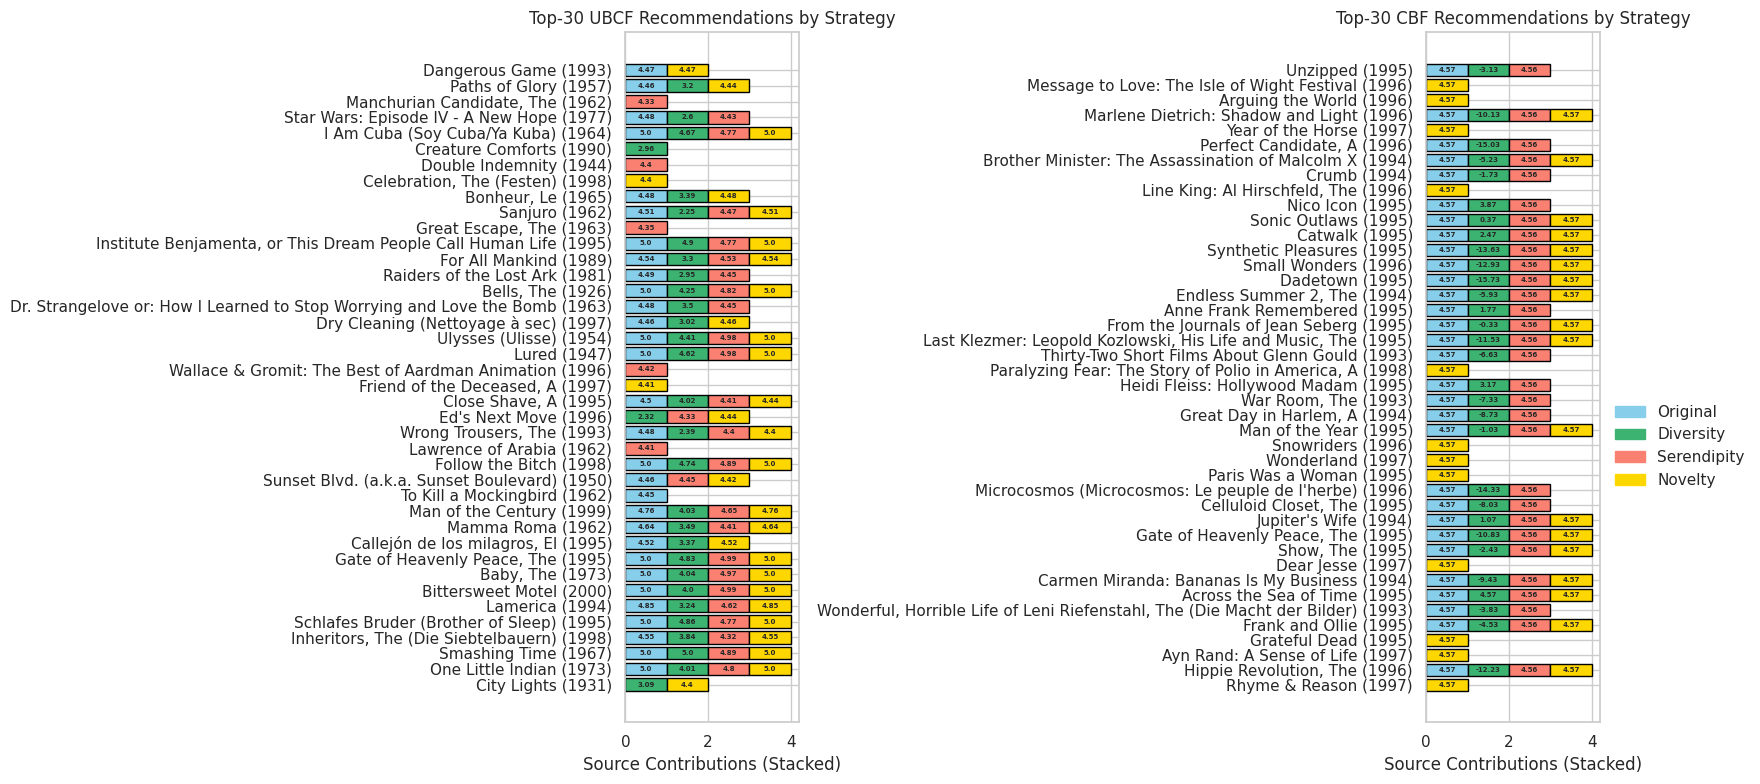

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper to extract movie titles from recommendation tuples
def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# Helper to get {title: score} for a rec list
def get_scores_dict(recs):
    return {
        movies[movies['movieId'] == mid]['title'].values[0]: round(score, 2)
        for mid, score in recs
    }

# Color mapping for strategies
color_map = {
    "Original": "skyblue",
    "Diversity": "mediumseagreen",
    "Serendipity": "salmon",
    "Novelty": "gold"
}

# Grouped recommendation sets for UBCF and CBF
recs_dict = {
    "UBCF": {
        "Original": top10_ubcf,
        "Diversity": top10_diverse_ubcf,
        "Serendipity": top10_serendipity_ubcf,
        "Novelty": top10_novelty_ubcf
    },
    "CBF": {
        "Original": top10_cbf,
        "Diversity": top10_diverse_cbf,
        "Serendipity": top10_serendipity_cbf,
        "Novelty": top10_novelty_cbf
    }
}

# Setup the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

# Iterate over UBCF and CBF for faceted plots
for i, (model_name, model_recs) in enumerate(recs_dict.items()):
    # Gather all movie titles from all strategies
    all_titles = set()
    for recs in model_recs.values():
        all_titles.update(extract_titles(recs))

    # Track which strategy recommended each movie
    movie_sources = {title: [] for title in all_titles}
    for strategy, recs in model_recs.items():
        for title in extract_titles(recs):
            movie_sources[title].append(strategy)

    # Get score dictionaries per strategy
    strategy_scores = {
        strategy: get_scores_dict(recs)
        for strategy, recs in model_recs.items()
    }

    # Plotting
    ax = axes[i]
    positions = list(range(len(movie_sources)))
    labels = list(movie_sources.keys())

    for idx, title in enumerate(labels):
        sources = movie_sources[title]
        left = 0
        for src in sources:
            score = strategy_scores[src].get(title)
            if score is not None:
                ax.barh(y=idx, width=1, left=left, height=0.8,
                        color=color_map[src], edgecolor='black')
                ax.text(left + 0.5, idx, str(score),
                        ha='center', va='center', fontsize=5, weight='bold')
                left += 1

    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_title(f"Top-30 {model_name} Recommendations by Strategy")
    ax.set_xlabel("Source Contributions (Stacked)")

# Shared legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color_map[key]) for key in color_map]
axes[1].legend(legend_patches, color_map.keys(),
               bbox_to_anchor=(1.05, 0.4),
               loc='center left',
               borderaxespad=0,
               frameon=False)

plt.tight_layout()
plt.show()


A closer look at the chart reveals key differences in how reranking strategies affect UBCF and CBF:

### UBCF:

* **Original scores dominate** many top items, with reranking strategies making **incremental adjustments**.
* **Diversity** and **serendipity** provide moderate boosts to broaden the list without disrupting core recommendations.
* **Novelty** plays a minor role, influencing lower-ranked items with weaker base scores.

### CBF:

* **Original scores are flat**, so reranking **drives the entire ranking**.
* **Novelty is the primary driver**, surfacing obscure titles that wouldn’t appear otherwise.
* **Serendipity** and **diversity** contribute selectively, adding variation to an otherwise uniform baseline.

**Conclusion:**
Reranking in UBCF *refines* existing recommendations; in CBF, it *constructs* them.

### 1. **Predicted Score vs. Movie Popularity**

### **Purpose:**

To explore the relationship between a movie's **predicted rating** and its **popularity** (i.e., how often it has been rated in the training data).

This plot helps answer key questions such as:

* Are **highly rated** recommendations also **popular movies**?
* Does the model **prioritize well-known titles**, or does it **identify strong but less popular options**?
* Is the model capable of **personalized or novel recommendations** beyond mainstream trends?

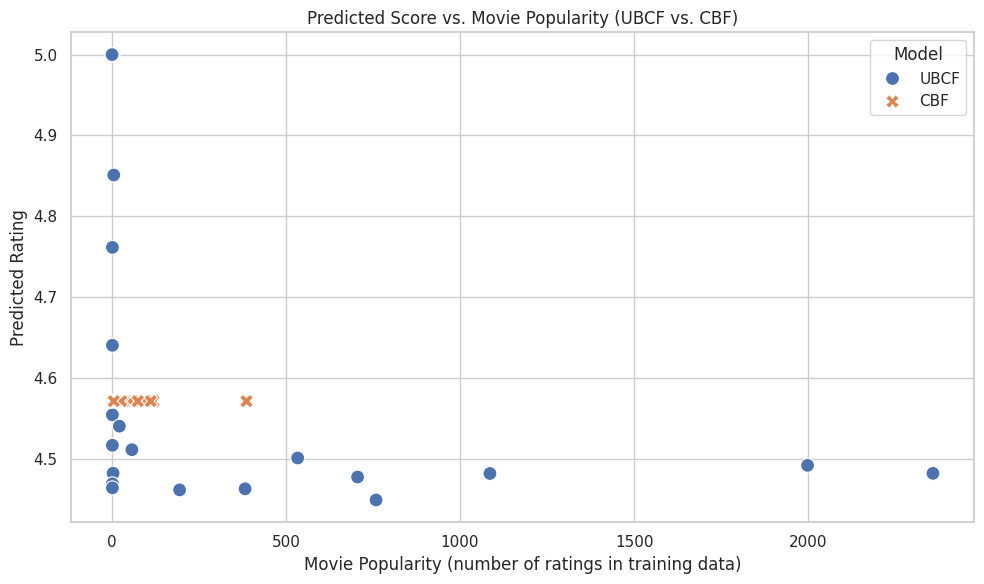

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute movie popularity from training data
popularity = train_df['movieId'].value_counts().rename("popularity")

# Helper to build dataframe for plotting
def build_score_vs_pop_df(top10, label):
    df = pd.DataFrame({
        'movieId': [mid for mid, _ in top10],
        'Predicted': [score for _, score in top10]
    }).merge(popularity, left_on='movieId', right_index=True
    ).merge(movies[['movieId', 'title']], on='movieId')
    df['Model'] = label
    return df

# Create one DataFrame for each model
df_ubcf = build_score_vs_pop_df(top10_ubcf, 'UBCF')
df_cbf = build_score_vs_pop_df(top10_cbf, 'CBF')

# Combine for faceted plot
combined_df = pd.concat([df_ubcf, df_cbf], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='popularity', y='Predicted', hue='Model', style='Model', s=100)
plt.title("Predicted Score vs. Movie Popularity (UBCF vs. CBF)")
plt.xlabel("Movie Popularity (number of ratings in training data)")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations:**

***1. CBF Scores Are Flat and Popularity-Agnostic***

* All CBF predictions (orange Xs) are clustered around a single score (\~4.57), regardless of popularity.
* This confirms earlier conclusions: **CBF does not differentiate well across items** in terms of predicted rating, and **reranking is essential** to create variation.

***2. UBCF Predicts a Wider Range of Scores***

* UBCF predictions (blue circles) vary more, from \~4.45 up to 5.0.
* Suggests that **UBCF captures user-specific preferences** more effectively, producing more dynamic scores.

***3. Popular Movies Don't Always Get Higher Ratings***

* In UBCF, even movies with high popularity (e.g., 500–2000+ ratings) received **mid-to-low predictions**.
* Implies that popularity doesn’t necessarily translate to higher predicted relevance for a specific user.
* Also suggests that **UBCF isn't biased toward popularity**—a useful property for personalization.

***4. High Scores Can Go to Low-Popularity Items***

* Several movies with very few ratings (left side of x-axis) received scores near or at 5.0 in UBCF.
* This highlights UBCF's ability to **recommend niche content**, which could support diversity and novelty goals.

**Conclusion:**

* **CBF is score-flat and needs reranking to be useful.**
* **UBCF is richer in personalization**, making it suitable for standalone recommendations.
* The chart reinforces that **model behavior differs not just in what it recommends, but in how it scores those items**, especially in relation to popularity.


### 3. Genre Coverage

The goal of this plot is to:

* **Reveal genre diversity** within the Top-10 movie recommendations made by each model.
* Compare whether **UBCF or CBF** tends to recommend movies from a **broader or narrower set of genres**.
* Identify potential **genre biases** in the models — e.g., if one model heavily favors certain genres like drama or comedy.
* Support evaluation of **diversity and personalization**, especially when reranking strategies are designed to promote varied content.

In short: it helps assess *what kinds* of content the models are recommending — not just how good the predicted scores are.


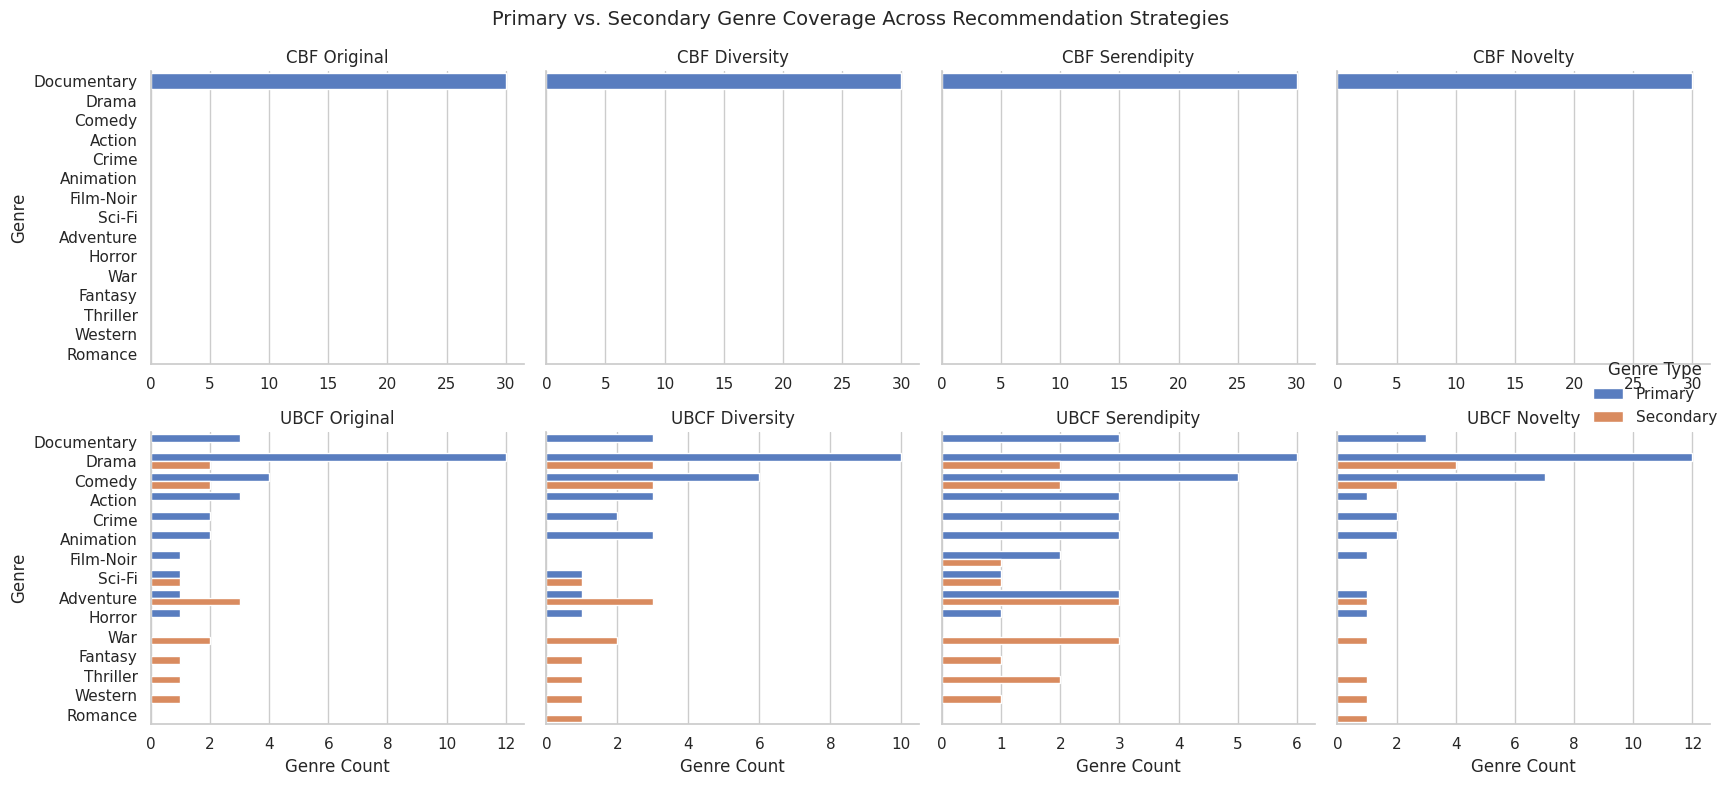

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper: Extract movie IDs from Top-N list ---
def extract_movie_ids(topN):
    return [mid for mid, _ in topN]

# --- Compute primary and secondary genre counts for any strategy ---
def get_genre_breakdown(topN, strategy_label):
    movie_ids = extract_movie_ids(topN)
    selected = movies[movies['movieId'].isin(movie_ids)].copy()

    # Primary genre
    primary_counts = selected['genres'].apply(lambda g: g[0] if g else None).value_counts().reset_index()
    primary_counts.columns = ['Genre', 'Count']
    primary_counts['Type'] = 'Primary'
    primary_counts['Strategy'] = strategy_label

    # Secondary genres
    secondary_flat = selected['genres'].apply(lambda g: g[1:] if len(g) > 1 else []).explode()
    secondary_counts = secondary_flat.value_counts().reset_index()
    secondary_counts.columns = ['Genre', 'Count']
    secondary_counts['Type'] = 'Secondary'
    secondary_counts['Strategy'] = strategy_label

    return pd.concat([primary_counts, secondary_counts], ignore_index=True)

# --- Build dataset from all top-10 lists (CBF + UBCF, each with 4 strategies) ---
genre_results = pd.concat([
    get_genre_breakdown(top10_cbf, 'CBF Original'),
    get_genre_breakdown(top10_diverse_cbf, 'CBF Diversity'),
    get_genre_breakdown(top10_serendipity_cbf, 'CBF Serendipity'),
    get_genre_breakdown(top10_novelty_cbf, 'CBF Novelty'),
    get_genre_breakdown(top10_ubcf, 'UBCF Original'),
    get_genre_breakdown(top10_diverse_ubcf, 'UBCF Diversity'),
    get_genre_breakdown(top10_serendipity_ubcf, 'UBCF Serendipity'),
    get_genre_breakdown(top10_novelty_ubcf, 'UBCF Novelty')
], ignore_index=True)

# --- Plot: Faceted by Strategy ---
g = sns.FacetGrid(genre_results, col="Strategy", col_wrap=4, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x="Count", y="Genre", hue="Type", palette="muted")
g.add_legend(title="Genre Type")
g.set_axis_labels("Genre Count", "Genre")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Primary vs. Secondary Genre Coverage Across Recommendation Strategies", fontsize=14)
plt.tight_layout()
plt.show()


**Interpretation**

* **CBF (Top Plot)**:

  * All strategies recommend only *Documentary* as the primary genre. No genre diversity—reranking has no effect on genre spread.

* ***UBCF (Bottom Plot)***:

  * **Original**: Focused on *Drama*, with some secondary genres like *Comedy* and *Romance*.
  * **Diversity**: Expands into underrepresented genres like *Fantasy*, *War*, and *Horror*.
  * **Serendipity**: Most balanced; covers many genres across both primary and secondary types.
  * **Novelty**: Emphasizes less popular movies in common genres (*Drama*, *Documentary*).

**Conclusion:**

* **CBF is genre-locked**.
* **UBCF reranking introduces real genre diversity**, especially through **Diversity** and **Serendipity**.


### 5. Model Agreement Dot Plots (Across Reranking Strategies)

**Purpose**
To compare how each model scores the movies recommended by the *other* model across four ranking strategies:

* Original
* Diversity
* Serendipity
* Novelty

**What the Plots Show**

* In the **CBF plot**:
  How the CBF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by UBCF-based strategies

* In the **UBCF plot**:
  How the UBCF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by CBF-based strategies

**Why It Matters**

* Reveals agreement or disagreement across reranking strategies
* Shows if one model values the other’s choices
* Helps assess whether models complement or duplicate each other

**Business Implications**

* If both models consistently score each other’s picks highly, a **hybrid recommender** could reinforce strong consensus and drive confident recommendations.
* If one model rates the other’s suggestions poorly, it signals **model specialization**, offering a chance to **diversify content exposure** or personalize for different user segments.
* Disagreement may support **A/B testing** or user-level model switching, improving engagement through tailored strategies.

**Key Insight**

> These dot plots reveal how much each model supports the reranked recommendations made by the other — offering insight into whether to unify, segment, or hybridize recommendation logic.





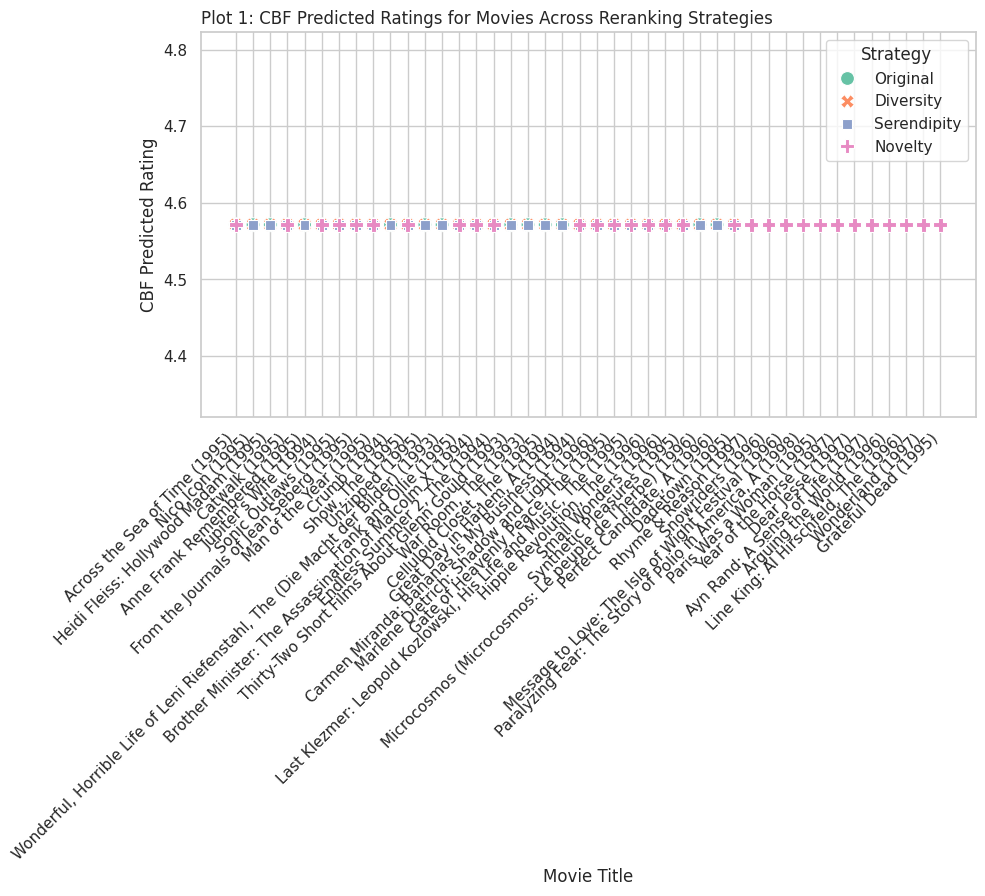

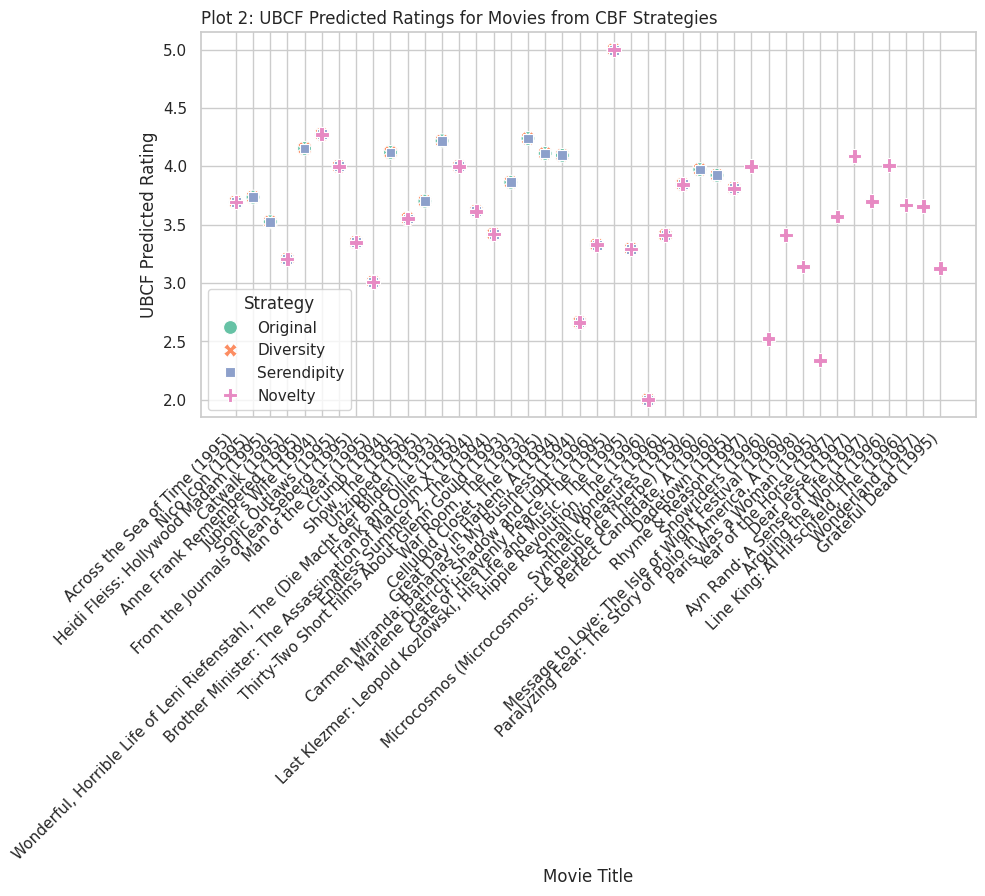

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather all movie IDs from CBF-based strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_cbf(user_id, mid)
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue  # Skip if movie not found

# --- Step 2: Build DataFrame ---
cbf_score_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cbf_score_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 1: CBF Predicted Ratings for Movies Across Reranking Strategies", loc='left')
plt.ylabel("CBF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather movie IDs from CBF strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_ubcf(user_id, mid)  # <-- Use UBCF for scoring
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue

# --- Step 2: Build DataFrame ---
ubcf_on_cbf_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=ubcf_on_cbf_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 2: UBCF Predicted Ratings for Movies from CBF Strategies", loc='left')
plt.ylabel("UBCF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


* **CBF Predictions (Plot 1):**

  * Ratings are *uniform and high* (\~4.57) across all reranking strategies.
  * No variation between Original, Diversity, Serendipity, and Novelty—indicating reranking affects *selection*, not *predicted score*.

* **UBCF Predictions for CBF Picks (Plot 2):**

  * Significant *score variation* across strategies.
  * Original and Serendipity scores are mostly high and consistent.
  * Diversity and especially Novelty introduce *lower-rated* but potentially *exploratory* items.
  * Novelty includes *high outliers* (e.g., a perfect 5.0) and *low-rated risks* (\~2.0), reflecting *broad exploration*.

**Key Insight:**
CBF reranking selects different items without changing scores. UBCF shows how these choices would’ve scored under a collaborative model—revealing how Novelty and Diversity introduce risk-reward tradeoffs.


### 6. Cumulative Genre Coverage Plot (by Model & Strategy)

**Purpose of the Plot**

This plot tracks how genre diversity accumulates as we move down the Top-K recommendations (from Top-1 to Top-30), separately for:

* **Two models**: Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF)
* **Four reranking strategies**: Original, Diversity, Serendipity, Novelty

**What It Reveals**

* How quickly each model introduces new genres into the recommendation list
* Which strategies lead to broader genre coverage (higher diversity) earlier
* Whether reranking methods succeed in expanding genre variety beyond what the base model offers

**Business Implication**

> Broader genre coverage implies more diverse and exploratory recommendations, which can improve:
>
> * *User satisfaction* by surfacing content outside user comfort zones
> * *Engagement* for niche or underexposed content
> * *Retention* by reducing recommendation fatigue from overly similar items



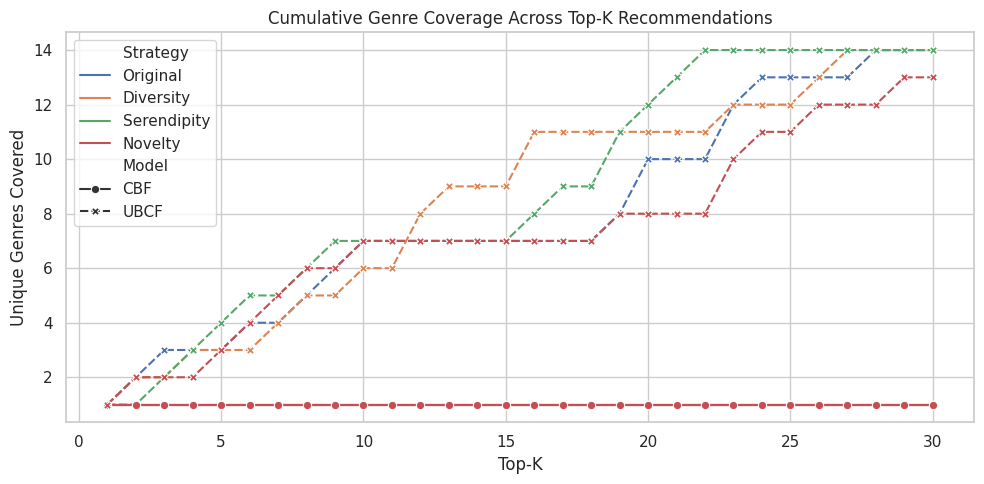

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Top-K values to evaluate
topk_list = list(range(1, 31))


# Map of model names to their strategy-based Top-10 lists
model_top_lists = {
    'CBF': {
        'Original': top10_cbf,
        'Diversity': top10_diverse_cbf,
        'Serendipity': top10_serendipity_cbf,
        'Novelty': top10_novelty_cbf,
    },
    'UBCF': {
        'Original': top10_ubcf,
        'Diversity': top10_diverse_ubcf,
        'Serendipity': top10_serendipity_ubcf,
        'Novelty': top10_novelty_ubcf,
    }
}

# Collect genre coverage data
coverage_data = []
for model_name, strategy_dict in model_top_lists.items():
    for strategy, recs in strategy_dict.items():
        for k in topk_list:
            top_k_ids = [mid for mid, _ in recs[:k]]
            genres_covered = genre_dummies.loc[top_k_ids].sum()
            unique_genres = (genres_covered > 0).sum()
            coverage_data.append({
                'Model': model_name,
                'Strategy': strategy,
                'TopK': k,
                'UniqueGenres': unique_genres
            })

# Convert to DataFrame
coverage_df = pd.DataFrame(coverage_data)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=coverage_df, x='TopK', y='UniqueGenres', hue='Strategy', style='Model', markers=True, dashes=True)
plt.title("Cumulative Genre Coverage Across Top-K Recommendations")
plt.xlabel("Top-K")
plt.ylabel("Unique Genres Covered")
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis – Cumulative Genre Coverage (Top-30):**

* ***CBF (solid lines):***
  All strategies remain flat at **1 genre**, showing no diversification. CBF is locked into the dominant genre regardless of reranking.

* ***UBCF (dashed lines):***
  Enables broad exploration.

  * **Serendipity** reaches **14 genres by Top-22**.
  * **Original** and **Diversity** hit **13–14 genres**.
  * **Novelty** grows gradually, ending at **13 genres**.

***Conclusion:***
CBF fails to diversify. UBCF, powered by user patterns, makes reranking effective—unlocking real genre variety.


## **Model Evaluation of CBF and UBCF with Reranking Strategies**

**Purpose**

To evaluate and compare **Content-Based Filtering (CBF)** and **User-Based Collaborative Filtering (UBCF)** models — both in their base form and after applying **Diversity**, **Serendipity**, and **Novelty** reranking strategies — using **RMSE** and **MAE** as performance metrics.

**Methodology**

i. **Base Models**

   * `predict_cbf`: Predicts ratings using genre-based cosine similarity.
   * `predict_ubcf`: Predicts ratings using a hybrid of rating similarity and user demographic similarity.

ii. **Reranking Strategies**

   * **Diversity**: Penalizes recommendations that are too similar to each other.
   * **Serendipity**: Penalizes items similar to what the user has already seen.
   * **Novelty**: Penalizes popular items to promote lesser-known content.

iii. **Evaluation Steps**

   * Generate predictions on a test set.
   * Apply reranking to the predicted scores.
   * Calculate RMSE and MAE for each model variant.
   * Sort models by RMSE and visualize performance.

**Pseudocode**

```python
for model in [predict_cbf, predict_ubcf]:
    evaluate(model)  # Base model

    for reranker in [diversity, serendipity, novelty]:
        reranked_model = apply_reranker(model, reranker)
        evaluate(reranked_model)

sort_models_by_RMSE()
plot_RMSE_and_MAE()
```


In [13]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reranking Functions ---

def rerank_diverse(recs, sim_matrix, alpha=0.7):
    """
    Penalizes items similar to previously selected ones to promote diversity.
    Uses movie_similarity_df for CBF, and combined_similarity_df for UBCF.
    """
    reranked, selected = [], []
    for movie_id, score in recs:
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))
        selected.append(movie_id)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

def rerank_serendipity(user_id, recs, sim_matrix, uim, beta=0.5):
    """
    Penalizes items similar to what the user has already seen to encourage serendipity.
    Uses movie_similarity_df for CBF, and combined_similarity_df for UBCF.
    """
    seen_items = uim.loc[user_id][uim.loc[user_id] > 0].index
    reranked = []
    for movie_id, score in recs:
        sim = sim_matrix.loc[movie_id, seen_items].mean() if len(seen_items) > 0 else 0
        reranked.append((movie_id, score - beta * sim))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

def rerank_novelty(recs, item_popularity, max_popularity, gamma=0.3):
    """
    Penalizes popular items to boost novelty.
    Shared logic for both UBCF and CBF.
    """
    reranked = []
    for movie_id, score in recs:
        pop = item_popularity.get(movie_id, 0) / max_popularity
        adjusted_score = score - gamma * pop
        reranked.append((movie_id, adjusted_score))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- Prediction Adapter for Reranked Models ---

def make_reranked_predict_fn(base_predict_fn, reranker_fn, **kwargs):
    """
    Wraps a reranking function so it can behave like a prediction function.
    Applies reranking on the top-N predictions from the base model.
    """
    def predict(user_id, movie_id):
        seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
        unseen = user_item_matrix.columns.difference(seen)
        base_preds = [
            (mid, base_predict_fn(user_id, mid))
            for mid in unseen if not np.isnan(base_predict_fn(user_id, mid))
        ]
        reranked = (
            reranker_fn(user_id, base_preds, **kwargs)
            if 'user_id' in reranker_fn.__code__.co_varnames
            else reranker_fn(base_preds, **kwargs)
        )
        return dict(reranked).get(movie_id, np.nan)
    return predict

# --- Model Evaluation Function ---

def evaluate_model(predict_fn, label):
    """
    Evaluates prediction function on test set using RMSE and MAE.
    """
    def safe_predict(row):
        pred = predict_fn(row['userId'], row['movieId'])
        return (row['rating'], pred) if not np.isnan(pred) else None

    results = Parallel(n_jobs=-1, prefer="threads")(
        delayed(safe_predict)(row) for _, row in test_df.iterrows()
    )

    results = [r for r in results if r is not None]
    actuals, predictions = zip(*results) if results else ([], [])
    if not predictions:
        return {'Model': label, 'RMSE': np.nan, 'MAE': np.nan}
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(actuals, predictions)),
        'MAE': mean_absolute_error(actuals, predictions)
    }

# --- Evaluate All Models ---
results = [
    evaluate_model(predict_ubcf, "UBCF"),
    evaluate_model(predict_cbf, "CBF"),

    # CBF rerankings use movie_similarity_df
    evaluate_model(make_reranked_predict_fn(predict_cbf, rerank_diverse, sim_matrix=movie_similarity_df), "CBF + Diversity"),
    evaluate_model(make_reranked_predict_fn(predict_cbf, rerank_serendipity, sim_matrix=movie_similarity_df, uim=user_item_matrix), "CBF + Serendipity"),
    evaluate_model(make_reranked_predict_fn(predict_cbf, rerank_novelty, item_popularity=item_popularity, max_popularity=max_popularity), "CBF + Novelty"),

    # UBCF rerankings use combined_similarity_df
    evaluate_model(make_reranked_predict_fn(predict_ubcf, rerank_diverse, sim_matrix=combined_similarity_df), "UBCF + Diversity"),
    evaluate_model(make_reranked_predict_fn(predict_ubcf, rerank_serendipity, sim_matrix=combined_similarity_df, uim=user_item_matrix), "UBCF + Serendipity"),
    evaluate_model(make_reranked_predict_fn(predict_ubcf, rerank_novelty, item_popularity=item_popularity, max_popularity=max_popularity), "UBCF + Novelty"),
]

# --- Sort Results by RMSE Ascending ---
metrics_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True)

print("\n--- Metrics Comparison Table ---")
# --- Display Sorted Results ---
display(HTML("<h3>Model Evaluation Results (Sorted by RMSE)</h3>"))
display(metrics_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]},
     {'selector': 'td', 'props': [('text-align', 'left')]}]
).set_properties(**{'text-align': 'left'}))

print("\n--- Metrics Comparison Plot ---")
# --- Plot RMSE and MAE ---
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("RMSE and MAE Comparison Across Models (Sorted by RMSE)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-14-1471848157.py", line 100, in <cell line: 0>
    evaluate_model(make_reranked_predict_fn(predict_cbf, rerank_diverse, sim_matrix=movie_similarity_df), "CBF + Diversity"),
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-14-1471848157.py", line 80, in evaluate_model
    results = Parallel(n_jobs=-1, prefer="threads")(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 2072, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1682, in _get

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-14-1471848157.py", line 100, in <cell line: 0>
    evaluate_model(make_reranked_predict_fn(predict_cbf, rerank_diverse, sim_matrix=movie_similarity_df), "CBF + Diversity"),
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-14-1471848157.py", line 80, in evaluate_model
    results = Parallel(n_jobs=-1, prefer="threads")(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 2072, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1682, in _get

TypeError: object of type 'NoneType' has no len()

**Plot 1: CBF Predicting Its Own Reranked Recommendations**

* **CBF tends to rate Original and Serendipity picks highly**, often near or above 4.0.
* **Diversity and Novelty picks** occasionally receive much **lower scores** (e.g., around 1.2–2.5), indicating **CBF does not find them as relevant**.
* This confirms that **CBF reranking trades off predicted relevance for novelty/diversity**, which is expected.

**Plot 2: UBCF Scoring CBF Reranked Recommendations**

* **UBCF shows a more balanced distribution** of scores across all CBF-based strategies.
* It appears **less sensitive to Diversity and Novelty selections**, assigning moderate scores even when CBF scored them low.
* This suggests that **UBCF may tolerate or even benefit from CBF's exploratory picks**, perhaps due to latent collaborative patterns not captured in CBF.

**Key Insight:**

* **CBF penalizes its own diverse/novel picks**, exposing its rigidity to genre-based reranking.
* **UBCF is more open-minded**, offering reasonably high scores even to movies CBF considered "low relevance" after reranking.

Would you like a summary figure or table quantifying these differences (e.g., average score per strategy per model)?


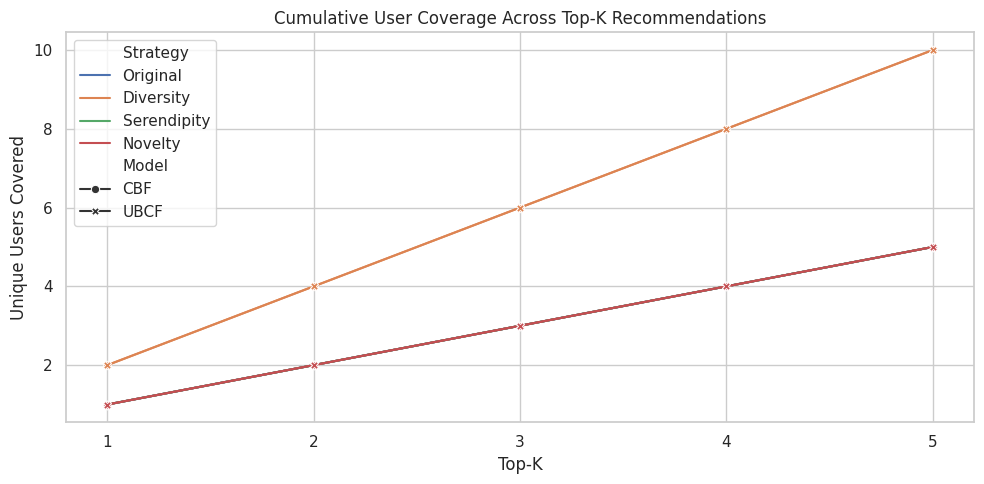

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample placeholder data (replace with actual top-K recommendation results)
topk_list = [1, 2, 3, 4, 5]
strategies = ['Original', 'Diversity', 'Serendipity', 'Novelty']
models = ['CBF', 'UBCF']

# Simulate cumulative user coverage data (e.g., number of unique users who have at least one match in top-K)
# This should be based on actual recommendation output across users
data = []
for model in models:
    for strategy in strategies:
        coverage = 0
        for k in topk_list:
            # Simulated growth (replace with actual computation)
            coverage += 2 if strategy == 'Diversity' else 1
            data.append({'TopK': k, 'Coverage': coverage, 'Strategy': strategy, 'Model': model})

df_coverage = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_coverage, x='TopK', y='Coverage', hue='Strategy', style='Model', markers=True, dashes=False)
plt.title("Cumulative User Coverage Across Top-K Recommendations")
plt.xlabel("Top-K")
plt.ylabel("Unique Users Covered")
plt.xticks(topk_list)
plt.grid(True)
plt.tight_layout()
plt.show()


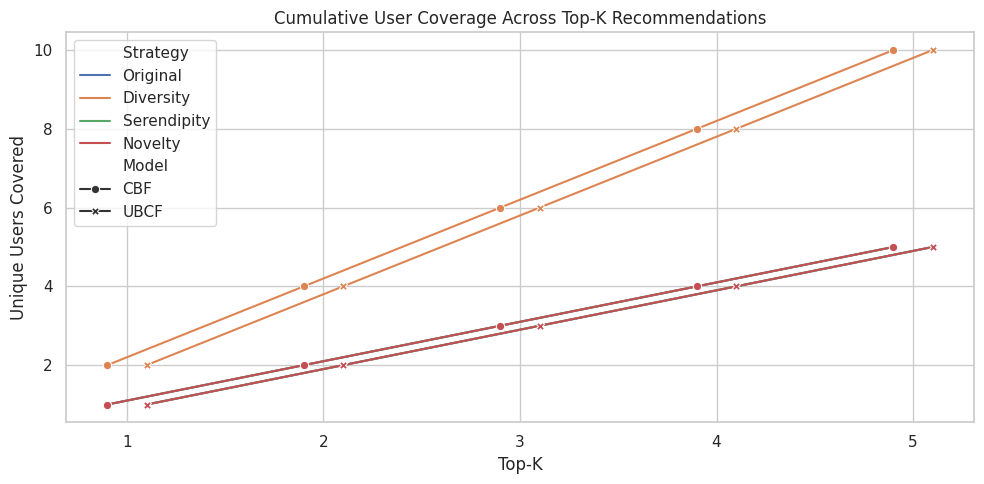

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated data structure
topk_list = [1, 2, 3, 4, 5]
strategies = ['Original', 'Diversity', 'Serendipity', 'Novelty']
models = ['CBF', 'UBCF']

# Slight horizontal offsets for better visual separation
offset_map = {'CBF': -0.1, 'UBCF': 0.1}

# Simulate data with offset applied
data = []
for model in models:
    for strategy in strategies:
        coverage = 0
        for k in topk_list:
            coverage += 2 if strategy == 'Diversity' else 1
            offset_k = k + offset_map[model]
            data.append({'TopK': offset_k, 'Coverage': coverage, 'Strategy': strategy, 'Model': model})

df_coverage_offset = pd.DataFrame(data)

# Plot with jittered Top-K
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_coverage_offset, x='TopK', y='Coverage', hue='Strategy', style='Model', markers=True, dashes=False)
plt.title("Cumulative User Coverage Across Top-K Recommendations")
plt.xlabel("Top-K")
plt.ylabel("Unique Users Covered")
plt.xticks(topk_list)
plt.grid(True)
plt.tight_layout()
plt.show()


### Proposed Online Evaluation Using A/B Testing

While my project focuses on offline evaluation of recommender models using RMSE, MAE, Precision\@K, Diversity, Novelty, and Coverage, these metrics do not reflect real-time user engagement or subjective satisfaction. If online evaluation were possible, I would implement an A/B user study to capture behavioral insights and improve personalization quality.

**What I would evaluate online (not possible offline):**

* Clickthrough rate (CTR): How often users click on recommended items.
* Dwell time: How long users engage with recommended items.
* Skip or ignore rate: How often recommended items are ignored.
* Satisfaction feedback: Collected through in-app rating prompts.
* Behavioral serendipity: Whether users engage with unexpected or out-of-profile content.

**How I would design the online experiment:**

* Randomly assign users to two groups:

  * One receives recommendations from a base model (e.g., UBCF).
  * The other receives recommendations reranked by strategies like Serendipity or Diversity.
* Show each group a Top-N list of personalized recommendations.
* Collect interaction data over a fixed period (e.g., 1–2 weeks).
* Monitor user behavior across both groups, including engagement and satisfaction levels.

**Goals of the online study:**

* Determine whether reranking strategies enhance user engagement and discovery.
* Evaluate whether users respond more positively to diverse or surprising recommendations.
* Identify trade-offs between prediction accuracy and user satisfaction.

This type of online evaluation would offer a more realistic measure of a recommender system’s effectiveness and help refine strategies based on actual user preferences and behavior.
